# Artificial Neural Netowork

In this tutorial, I will showcase how to use aritifical neural network (ANN) in Tensorflow.

Tensorflow is a deep learning package implemented on python. Very broadly speaking, tensorflow allows us to use GPU without much effort. It is a package that is an overlay ontop of popular math-packages, like numpy, scipy and sklearn, and converts arrays into something GPU can handle. You can also use pytorch, if you prefer, but the paper we are reproducing utilizes tensorflow. Please check tensorflow website for more details [TensorFlow Website](https://www.tensorflow.org/)

Please begin by running the below code to install the relevant packages. If there is some kind of error, remove the -q to display error.

In [1]:
!pip install -q tensorflow
!pip install -q numpy 
!pip install matplotlib

![title](img/ANN_network.png)
ANN contains 3 main parts.
1) The input layer: Vectorized data. For single cell we will preprocess the data to about ~1000 features. See the [Scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) on clustering to see how this is performed
2) Hidden layer: This is the 'black box' portion of deep learning. We need to determine how many hidden layers we want, and the number of nodes (the circles) we want
3) Output layers: This is where we compare our prediction with the true solution. For classification, if there are 10 classes, we would have 10 nodes. For regression, this will depend on the architecture.

# Notation

Let us begin by talking breifly about the notation.
1) Our data will be $X \in \mathbb{R}^{M,N}$. This means we have $M$ data, and $N$ features, where the rows of matrix $X$ correspond to each data, and the columns indicate the features. Let $Y \in \mathbb{R}^N$ be the labels, or the true cell type. For classification problem, the labels will be some integer, and for regression problem, the label will be some number. 

An example of our data may look like the following:

data | gene 1 | gene 2| ... | gene N|Label|
| :-: | :-: | :-: |:-: | :-:|:-:|
cell 1 | 0 | 10 | ... | 0 | Oligodendrocytes |
cell 2 | 0.1 | 0 | ... | 100|Oligodendrocytes |
... | ... | ... | ... | ...|...|
cell M | 100 | 0| ... | 100|Astrocytes |

2) The $i$-th data will be often be denoted as $\mathbf{x}_i$, which is a vector of length $N$ (features). Then, $\mathbf{x}_i = (x_{i1}, ..., x_{ij}, ...,x_{iN})$, where $x_{ij}$ is the $j$-th feature of data $i$.

3) Similarly, the $i$-th label is denoted as $y_i$

# Data loading

Let us start by first obtaining the digits dataset from tensorflow.

First, import relevant librarie.
Run the following code to load the digits dataset. 

MNIST is a 28 by 28 digit image, where the goal is to classify the digits from 1 to 10.

We will do a scaling on the data so that each pixel has a value between 0 and 1

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt #this is for plotting our digits
import numpy as np
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

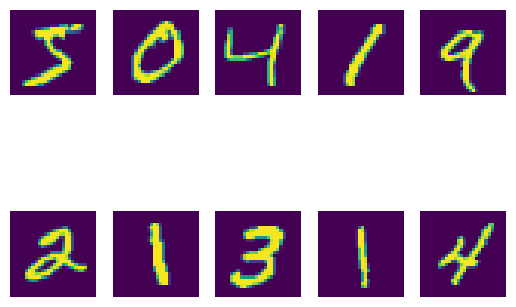

In [3]:
fig, ax = plt.subplots(2, 5)
row, col = 0, 0
for idx in range(10):
    ax[row, col].imshow(x_train[idx])
    ax[row, col].axis('off')
    col += 1
    if col == 5:
        row = 1; col =0

MNIST has 60,000 image as a training set, and 10,000 images as a testing set. That is, we train our machine learning model with the 60,000 images, and validate our model using the testing set.

For the sake of learning the material, this is very big, and is not practicle. I will reduce the training set to 1000 and the testing set to 100.

In [4]:
def mnist_subset(x_train, y_train, subsample = 1000):
    numClass = int(subsample / 10)
    new_x_train = np.zeros([numClass * 10, x_train.shape[1], x_train.shape[2]])
    new_y_train = np.zeros([numClass * 10])
    for label in range(10):
        index = np.where(y_train == label)[0]
        new_x_train[label*numClass:(label+1)*numClass, :, :] = x_train[index[:numClass], :, :]
        new_y_train[label*numClass:(label+1)*numClass] = y_train[index[:numClass]]
    return new_x_train, new_y_train
    

In [5]:
#skip this line if you want to do the full data
x_train, y_train = mnist_subset(x_train, y_train, subsample = 1000)
x_test, y_test = mnist_subset(x_test, y_test, subsample = 100)
print('Size of data')
print('training', x_train.shape)
print('testing', x_test.shape)

Size of data
training (1000, 28, 28)
testing (100, 28, 28)


# ANN architecture: Feed Forward
![title](img/neuron.png)

1) Each neuron (the circle in the figure above) requires an input, weight, bias and activation
2) Input is either the raw data or the hidden layer.
3) Each neuron is computed as the following 
\begin{align*}
    h = \sum_{i=1}^m w_ix_i + b
\end{align*}
where $b$ is the bias, and $w_i$ is the weights.

If we only have 1 neuron, this is essentially a line of best fit equation,
\begin{align*}
    y = a_1x_1 + a_2x_2 + ... + a_mx_m + b
\end{align*}

4) The activation function is a nonlinear function that converts $h$ to some positive number. We utilize activation to introduce nonlinearity to deep learning models. Otherwise, deep learning will just be a bunch of linear regression put together.

5) Comon activation functions are ReLu, sigmoid, softmax. See tensorflow's page for all the different types. [Tensor Flow activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

![title](img/ANN_network.png)

Now, if we consider a group of neurons, we have to use matrix notation.

1) The input layer, we denote $x$. This is essentially your raw data. Then, the first hidden layer $H_1$ is defined as 
\begin{align*}
H_1 = xW_1 + b_1
\end{align*}
In this example, $x \in \mathbb{R}^{4}$, $W_1 \in \mathbb{R}^{4 \times 5}$, and $b_1 \in \mathbb{R}^{5}$, and $H_1 \in \mathbb{R}^{4 \times 5}$, where $M$ is the number of data.
2) Then, we use the activation function $f_1$
\begin{align*}
    f_1 = ReLu(H_1)
\end{align*}

3) The second hidden layer $H_2$ will be computed using the input $f_1$ from the previous layer.
\begin{align*}
H_2 = f_1W_2 + b_2
\end{align*}
4) One again, we use an activation function
\begin{align*}
    f_2 = ReLu(H_2)
\end{align*}

5) Now, we compute the output layer, which is essentially the exact same thing
\begin{align*}
    H_3 = f_2W_3 + b_3
\end{align*}

The only difference here is that the number of output layer is predetermined. If we have 10 class (as in the MNIST data), we will have 10 nodes.

6) Often times for classification, we use softmax function for the output layers
\begin{align*}
    \hat{y} = softmax(H_3)
\end{align*}
where $softmax = \frac{e^{H_{3}^i}}{\sum e^{H_{3}^i}}$

# ANN: Back Propagation
![title](img/backprop.png)
Now, the only thing left to do is determine what the weights, $W_1, W_2, W_3$ and the biases $b_1, b_2, b_3$ are. These quantities are obtained via lots of derivative.

Before we begin the back propagation, we need to define a loss function. I would refer to this video on [cross entropy](https://youtu.be/YtebGVx-Fxw?si=x3c88U4bkJ1A4zfe) to learn about why we use cross-entropy function

The loss function is given as
\begin{align*}
    L = - \sum_i y_i \log(\hat{y})_i)
\end{align*}
where $y_i$ is the true label, and $\hat{y}_i$ is the predicted label from setp (6).

Compute the partial derivative with respect to $W_1, W_2, W_3, b_1, b_2, b_3$ to obtain the weights and biases

It is very much worth your time to calculate these derivatives, if you are interested in pursuing some kind of career in deep learning. Otherwise, for the sake of the project, we will just assume these derivatives are ok.

# Tensorflow implementation

We will use the 'Sequential' model to construct our ANN. I will also use Relu for the activation function.

Sequential is useful for stacking layers where each layer has one input tensor and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the Flatten, Dense, and Dropout layers.


In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),  #This is just to convert the image to a vector of length 28*28
  tf.keras.layers.Dense(256, activation='relu'),   #256 is the number of noden in hiden layer 1
  tf.keras.layers.Dense(128, activation='relu'),   # number of nodes in hiden layer 2 
  tf.keras.layers.Dense(10)    #output layer
])

Now, we need an output from our last layer, which has 10 nodes.

In [7]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.6608275 , -0.2821433 ,  0.02270977, -0.27555802, -0.22411369,
        -0.18071389, -0.59717596,  0.20937912,  0.06395733,  0.28594387]],
      dtype=float32)

Notice that these values have negatives, and it is difficult to understand what the heck these values mean. Therefore, we apply the softmax activation function to convert these values into probabilities.

In [8]:
tf.nn.softmax(predictions).numpy()

array([[0.05824145, 0.08505359, 0.11536887, 0.08561555, 0.09013523,
        0.09413321, 0.06206914, 0.13904588, 0.12022707, 0.15011005]],
      dtype=float32)

This means that the probability of digit being '0' is the first entry, the probability of digit '1' is the second entry, and so on

Now, we define the loss function (the cross entropy)

In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Now, we are basically done. The last step is to train our model using our 1,000 training data. We are using the 'adam' optimizer. This is a optimization scheme that utilizes stochastic gradient descent, which is essentially a computing the partial derivatives, but only using a subset of the data to speed up computation. See this [video](https://www.youtube.com/watch?v=vMh0zPT0tLI) for a quick tutorial

In machine learning 'epoch' means number of iteration.

In [11]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 2ms/step - loss: 1.3438 - accuracy: 0.6130
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.8790
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2858 - accuracy: 0.9310
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.9610
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1165 - accuracy: 0.9730


In [12]:
model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.3266 - accuracy: 0.8800 - 93ms/epoch - 23ms/step


[0.32657182216644287, 0.8799999952316284]

Our evaluation show that with our testing set, we get ~90% accuracy.

# Extension to ANN

We have now done the most basic ANN.

It is really up to the researchers to fine tune parameters to get the best results.

for example, we can change the number of nodes in the hidden layers and change the activation function. 

Lastly, I want to introduce the concept called 'Drop out'

![title](img/ANN_dropout.png)

In deep learning, we have a concept call 'over fitting', where our model now fits to the noise, rather than the useful data. We introduce a concept called 'drop out' to reduce the effect of overfitting. There are 2 types of dropout
1) Eliminate a node in the hidden layer
2) Eliminate some of the connections.

Both are valid strategies, and luckily, tensorflow has a nice implementation. I set the drop out to be 20%, ie we eliminate 20% of the nodes.

In [13]:
model_dropout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
model_dropout.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model_dropout.fit(x_train, y_train, epochs=5)

Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 1.4873 - accuracy: 0.5590
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.7960
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8840
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.3273 - accuracy: 0.9020
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2523 - accuracy: 0.9280


In [15]:
model_dropout.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.3495 - accuracy: 0.8700 - 79ms/epoch - 20ms/step


[0.3494838774204254, 0.8700000047683716]